<a href="https://colab.research.google.com/github/Zinuox/github-slideshow/blob/master/Copy_of_ps5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EECS 442/504 PS5: Scene Recognition

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

[Your first name] [Your last name], [Your UMich uniqname]

__Important__: after you download the .ipynb file, please name it as __"PS\<this_ps_number\>_\<your_uniqname\>.ipynb"__ before you submit it to canvas. Example: adam_01101100.ipynb.





__Note__: There are cells in this notebook that are specific to 504 students, if you are a 442 student please delete/comment them out while submitting the notebook/the pdf file.


# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm
  
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Construct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [ ]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2022-10-12 15:10:45--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  10.6MB/s    in 58s     

2022-10-12 15:11:44 (8.72 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [ ]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

## Step 1: Build dataloaders for train, val, and test

In [ ]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    """
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.
    """

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    ###########################################################################
    # TODO: Step 1: Build transformations for the dataset.                    #
    # You need to construct a data transformation that does three             #
    # preprocessing steps in order:                                           #
    # I. Resize the image to input_size using transforms.Resize               #
    # II. Convert the image to PyTorch tensor using transforms.ToTensor       #
    # III. Normalize the images with the provided mean and std parameters     #
    # using transforms.Normalize. These parameters are accumulated from a     #
    # large number of training samples.                                       #
    # You can use transforms.Compose to combine the above three               #
    # transformations. Store the combined transforms in the variable          #
    # 'composed_transform'.                                                   #
    ###########################################################################
    composed_transform = transforms.Compose([transforms.Resize(input_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean, std) ])
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    # We write the remaining part of the dataloader for you.  
    # You are encouraged to go through this.

    ###########################################################################
    # Step 2: Build dataloaders.                                              #
    # I. We use torch.datasets.ImageFolder with the provided data_dir and the #
    # data transfomations you created in step 1 to construct pytorch datasets #
    # for training, validation, and testing.                                  #
    # II. Then we use torch.utils.data.DataLoader to build dataloaders with   #
    # the constructed pytorch datasets. You need to enable shuffling for      #
    # the training set. Set num_workers=2 to speed up dataloading.            #
    # III. Finally, we put the dataloaders into a dictionary.                 #
    ###########################################################################

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}

    return dataloaders_dict

In [ ]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 10000


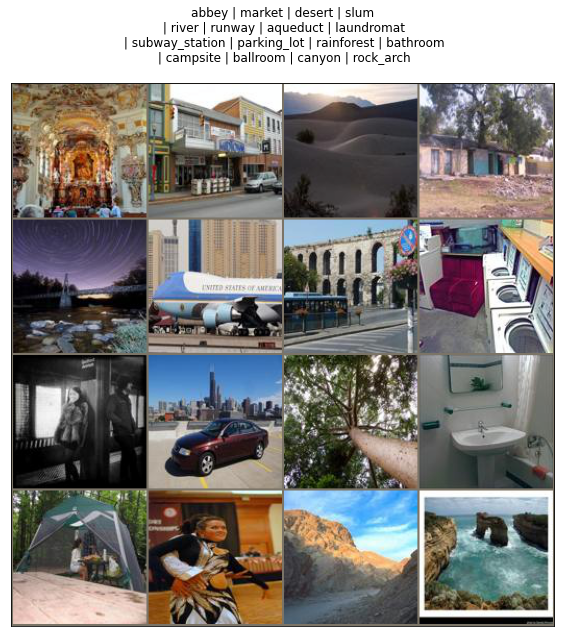

In [ ]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## Step 2. Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__

![alt text](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![alt text](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [ ]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    """
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    """

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [ ]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output 
# channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):
    """
    Return a nn.Sequential object containing all layers to get the features 
    using the CNN. (That is, before the Average pooling layer in the two 
    pictures above). 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer 
                  should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction
                layers. For use of torch.nn.Sequential, please refer to 
                PyTorch documentation.
    """
    ###########################################################################
    # TODO: Construct the neural net architecture from cfg. You should use    #
    # nn.Sequential().                                                        #
    ###########################################################################
    # features = nn.Sequential()
    features_layers = []
    prev = 3
    for layer in cfg:
      if layer == 'M':
        features_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
      else:
        features_layers.append(nn.Conv2d(prev, layer, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        if batch_norm:
          features_layers.append(nn.BatchNorm2d(layer, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        features_layers.append(nn.ReLU(inplace=True))
        prev = layer
    features = nn.Sequential(*features_layers)

    
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        #######################################################################
        # TODO: Construct the final FC layers using nn.Sequential.            #
        # Note: The average pooling layer has been defined by us above.       #
        #######################################################################        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=3200, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=256, out_features=100, bias=True))
        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with 
# the one given in the instructions above. 
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## Step 3. Build small ResNet model (EECS 504)

Please follow this figure to build the Residual Block and the Resnet model. We already implemented the back bone of the resnet model. You have to code the ResNet Block and the classifier part which are shown in the figure.

__ResNet architecture__

![alt text](https://drive.google.com/uc?id=1IlNfXwxYzTJC3FtmydDs07Z5Z9IWatde)





In [ ]:
# # For EECS 504 students only other please delete/comment this cell

# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride = 1):
#         super(ResidualBlock, self).__init__()
#         ###########################################################################
#         # TODO: Code the residual block as depicted in the above figure. You should use    #
#         # nn.Sequential().                                                        #
#         ###########################################################################
#         pass
#         #######################################################################
#         #                              END OF YOUR CODE                       #
#         #######################################################################
        
#     def forward(self, x):

#         ###########################################################################
#         # TODO: Code the forward pass for the residual block as depicted in the above figure. 
#         # Note: The relu activation function is after the skip connection.                                                        #
#         ###########################################################################
#         pass
#         #######################################################################
#         #                              END OF YOUR CODE                       #
#         #######################################################################
#         return out

In [ ]:
# # For EECS 504 students only other please delete/comment this cell

# class ResNet(nn.Module):
#     def __init__(self, block, layers, num_classes = 100):
#         super(ResNet, self).__init__()

#         ###########################################################################
#         # TODO: Construct the neural net architecture for the resnet model. You should use nn.Sequential().
#         # Note: We already implemented most of the network you just need to code the initial layers and insert the residual blocks.
#         ###########################################################################

#         self.backbone = nn.Sequential(
#                         ###########################################################################
#                         # TODO: Code the initial layers i.e the the strided convolution layer, batchnorm, relu, maxpool layer and the residual blocks
#                         #Hint: you have to make use of the "block" variable.
#                         ###########################################################################
#                         pass
#                         #######################################################################
#                         #                              END OF YOUR CODE                       #
#                         #######################################################################
#                         nn.Sequential(
#                         nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
#                         nn.BatchNorm2d(128),
#                         nn.ReLU()),
#                         ###########################################################################
#                         # TODO: Inser the residual block please follow the figure for the number of channels and the flow of layers.
#                         ###########################################################################
#                         pass
#                         #######################################################################
#                         #                              END OF YOUR CODE                       #
#                         #######################################################################
#                         nn.Sequential(
#                         nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
#                         nn.BatchNorm2d(256),
#                         nn.ReLU()),
#                         ###########################################################################
#                         # TODO: Inser the residual block please follow the figure for the number of channels and the flow of layers.
#                         ###########################################################################
#                         pass
#                         #######################################################################
#                         #                              END OF YOUR CODE                       #
#                         #######################################################################
#                         nn.Sequential(
#                         nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 1),
#                         nn.BatchNorm2d(512),
#                         nn.ReLU()),
#                         ###########################################################################
#                         # TODO: Inser the residual block please follow the figure for the number of channels and the flow of layers.
#                         ###########################################################################
#                         pass
#                         #######################################################################
#                         #                              END OF YOUR CODE                       #
#                         #######################################################################
#         )
        

#         self.avgpool = nn.AvgPool2d(2, stride=1)
#         self.fc = nn.Linear(512, num_classes)
        
    
#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         return x

In [ ]:
# # For EECS 504 students only other please delete/comment this cell

# resnet = ResNet(ResidualBlock, [1, 1, 1, 1], 100)
# print(resnet)
# print('Number of trainable parameters {}'.format(count_params(resnet)))


## Step 4: Build training/validation loops

You will write a function for training and validating the network. 

In [ ]:
def make_optimizer(model):
    """
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    """
    ###########################################################################
    # TODO: Create a SGD optimizer with learning rate=1e-2 and momentum=0.9.  #
    # HINT: Check out optim.SGD() and initialize it with the appropriate      #
    # parameters. We have imported torch.optim as optim for you above.        #
    ###########################################################################
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return optimizer

def get_loss():
    """
    Returns:
        criterion: pytorch loss. 
    """
    ###########################################################################
    # TODO: Create an instance of the cross entropy loss. This code           #
    # should be a one-liner.                                                  #
    ###########################################################################
    criterion = nn.CrossEntropyLoss()
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return criterion

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                ###############################################################
                # TODO:                                                       #
                # Please read all the inputs carefully!                       #
                # For "train" phase:                                          #
                # (i)   Compute the outputs using the model                   #
                #       Also, use the  outputs to calculate the class         #
                #       predicted by the model,                               #
                #       Store the predicted class in 'preds'                  #
                #       (Think: argmax of outputs across a dimension)         #
                #       torch.max() might help!                               #
                # (ii)  Use criterion to store the loss in 'loss'             # 
                # (iii) Update the model parameters                           #
                # Notes:                                                      #
                # - Don't forget to zero the gradients before beginning the   #
                # loop!                                                       #
                # - "val" phase is the same as train, but without backprop    #
                # - Compute the outputs (Same as "train", calculate 'preds'   #
                # too),                                                       #
                # - Calculate the loss and store it in 'loss'                 #
                ###############################################################
                # zero gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase== 'train'):
                  # (i) compute outputs using model, class predicted by model
                  outputs = model(inputs)
                  preds = torch.max(outputs, 1)[1]
                  # (ii) use criterion to store loss
                  loss = criterion(outputs, labels)
                  if phase == 'train':
                    loss.backward()
                    optimizer.step()

                ###############################################################
                #                         END OF YOUR CODE                    #
                ###############################################################

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained 
                # weights.
                # You should download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to 
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## Step 5. Train MiniVGG / MiniVGG-BN and ResNet model (EECS 504)

In [ ]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloaders and criterion function
input_size = 64
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [ ]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

Epoch 0/19
----------


100%|██████████| 704/704 [01:17<00:00,  9.07it/s]


train Loss: 4.5208 Acc: 0.0178


100%|██████████| 79/79 [00:07<00:00, 10.13it/s]


val Loss: 4.2782 Acc: 0.0367
Epoch 1/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.44it/s]


train Loss: 4.0902 Acc: 0.0627


100%|██████████| 79/79 [00:07<00:00, 10.10it/s]


val Loss: 3.9135 Acc: 0.0920
Epoch 2/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.54it/s]


train Loss: 3.7691 Acc: 0.1123


100%|██████████| 79/79 [00:07<00:00, 10.33it/s]


val Loss: 3.5864 Acc: 0.1400
Epoch 3/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.82it/s]


train Loss: 3.5574 Acc: 0.1475


100%|██████████| 79/79 [00:07<00:00, 10.34it/s]


val Loss: 3.4711 Acc: 0.1661
Epoch 4/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.75it/s]


train Loss: 3.3788 Acc: 0.1785


100%|██████████| 79/79 [00:07<00:00, 10.32it/s]


val Loss: 3.2265 Acc: 0.2021
Epoch 5/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.96it/s]


train Loss: 3.2383 Acc: 0.2025


100%|██████████| 79/79 [00:07<00:00, 10.44it/s]


val Loss: 3.2243 Acc: 0.2032
Epoch 6/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.64it/s]


train Loss: 3.1122 Acc: 0.2252


100%|██████████| 79/79 [00:07<00:00, 10.45it/s]


val Loss: 3.0744 Acc: 0.2322
Epoch 7/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.01it/s]


train Loss: 3.0015 Acc: 0.2471


100%|██████████| 79/79 [00:07<00:00, 10.47it/s]


val Loss: 2.9880 Acc: 0.2518
Epoch 8/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.81it/s]


train Loss: 2.8970 Acc: 0.2667


100%|██████████| 79/79 [00:07<00:00, 10.50it/s]


val Loss: 2.8971 Acc: 0.2753
Epoch 9/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.74it/s]


train Loss: 2.8055 Acc: 0.2866


100%|██████████| 79/79 [00:07<00:00, 10.65it/s]


val Loss: 2.8439 Acc: 0.2824
Epoch 10/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.79it/s]


train Loss: 2.7069 Acc: 0.3059


100%|██████████| 79/79 [00:07<00:00, 10.64it/s]


val Loss: 2.8155 Acc: 0.2907
Epoch 11/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.61it/s]


train Loss: 2.6181 Acc: 0.3253


100%|██████████| 79/79 [00:08<00:00,  8.93it/s]


val Loss: 2.7941 Acc: 0.2935
Epoch 12/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.14it/s]


train Loss: 2.5320 Acc: 0.3400


100%|██████████| 79/79 [00:07<00:00, 10.58it/s]


val Loss: 2.7791 Acc: 0.3014
Epoch 13/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.89it/s]


train Loss: 2.4466 Acc: 0.3586


100%|██████████| 79/79 [00:07<00:00, 10.42it/s]


val Loss: 2.7381 Acc: 0.3112
Epoch 14/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.09it/s]


train Loss: 2.3568 Acc: 0.3770


100%|██████████| 79/79 [00:07<00:00, 10.65it/s]


val Loss: 2.7403 Acc: 0.3080
Epoch 15/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.89it/s]


train Loss: 2.2838 Acc: 0.3928


100%|██████████| 79/79 [00:07<00:00, 10.72it/s]


val Loss: 2.7642 Acc: 0.3118
Epoch 16/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.06it/s]


train Loss: 2.1911 Acc: 0.4108


100%|██████████| 79/79 [00:07<00:00, 10.71it/s]


val Loss: 2.7710 Acc: 0.3129
Epoch 17/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.96it/s]


train Loss: 2.1119 Acc: 0.4253


100%|██████████| 79/79 [00:07<00:00, 10.53it/s]


val Loss: 2.7428 Acc: 0.3149
Epoch 18/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.08it/s]


train Loss: 2.0329 Acc: 0.4437


100%|██████████| 79/79 [00:07<00:00, 10.67it/s]


val Loss: 2.7930 Acc: 0.3090
Epoch 19/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.90it/s]


train Loss: 1.9566 Acc: 0.4580


100%|██████████| 79/79 [00:07<00:00, 10.56it/s]

val Loss: 2.7682 Acc: 0.3193
Best val Acc: 0.319300


In [ ]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

Epoch 0/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.67it/s]


train Loss: 4.1937 Acc: 0.0480


100%|██████████| 79/79 [00:07<00:00, 10.52it/s]


val Loss: 3.8860 Acc: 0.0923
Epoch 1/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.02it/s]


train Loss: 3.6020 Acc: 0.1307


100%|██████████| 79/79 [00:07<00:00, 10.40it/s]


val Loss: 3.3928 Acc: 0.1631
Epoch 2/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.70it/s]


train Loss: 3.3377 Acc: 0.1760


100%|██████████| 79/79 [00:07<00:00, 10.60it/s]


val Loss: 3.2535 Acc: 0.1881
Epoch 3/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.81it/s]


train Loss: 3.1761 Acc: 0.2059


100%|██████████| 79/79 [00:07<00:00, 10.56it/s]


val Loss: 3.0975 Acc: 0.2214
Epoch 4/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.67it/s]


train Loss: 3.0511 Acc: 0.2321


100%|██████████| 79/79 [00:07<00:00, 10.31it/s]


val Loss: 3.0030 Acc: 0.2410
Epoch 5/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.83it/s]


train Loss: 2.9511 Acc: 0.2511


100%|██████████| 79/79 [00:07<00:00, 10.49it/s]


val Loss: 2.8390 Acc: 0.2724
Epoch 6/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.78it/s]


train Loss: 2.8627 Acc: 0.2722


100%|██████████| 79/79 [00:07<00:00, 10.58it/s]


val Loss: 2.8219 Acc: 0.2773
Epoch 7/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.86it/s]


train Loss: 2.7743 Acc: 0.2887


100%|██████████| 79/79 [00:07<00:00, 10.37it/s]


val Loss: 2.8173 Acc: 0.2807
Epoch 8/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.66it/s]


train Loss: 2.7043 Acc: 0.3011


100%|██████████| 79/79 [00:07<00:00, 10.46it/s]


val Loss: 2.7050 Acc: 0.3057
Epoch 9/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.67it/s]


train Loss: 2.6335 Acc: 0.3174


100%|██████████| 79/79 [00:07<00:00, 10.44it/s]


val Loss: 2.7280 Acc: 0.2987
Epoch 10/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.74it/s]


train Loss: 2.5653 Acc: 0.3323


100%|██████████| 79/79 [00:07<00:00, 10.55it/s]


val Loss: 2.6502 Acc: 0.3174
Epoch 11/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.65it/s]


train Loss: 2.5039 Acc: 0.3463


100%|██████████| 79/79 [00:07<00:00, 10.52it/s]


val Loss: 2.6173 Acc: 0.3231
Epoch 12/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.83it/s]


train Loss: 2.4435 Acc: 0.3571


100%|██████████| 79/79 [00:07<00:00, 10.44it/s]


val Loss: 2.5959 Acc: 0.3290
Epoch 13/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.70it/s]


train Loss: 2.3801 Acc: 0.3704


100%|██████████| 79/79 [00:08<00:00,  9.33it/s]


val Loss: 2.5745 Acc: 0.3323
Epoch 14/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.84it/s]


train Loss: 2.3222 Acc: 0.3836


100%|██████████| 79/79 [00:07<00:00, 10.52it/s]


val Loss: 2.5812 Acc: 0.3361
Epoch 15/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.56it/s]


train Loss: 2.2684 Acc: 0.3931


100%|██████████| 79/79 [00:07<00:00, 10.38it/s]


val Loss: 2.5924 Acc: 0.3427
Epoch 16/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.79it/s]


train Loss: 2.2134 Acc: 0.4068


100%|██████████| 79/79 [00:07<00:00, 10.58it/s]


val Loss: 2.5839 Acc: 0.3388
Epoch 17/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.83it/s]


train Loss: 2.1603 Acc: 0.4180


100%|██████████| 79/79 [00:07<00:00, 10.41it/s]


val Loss: 2.5714 Acc: 0.3487
Epoch 18/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.65it/s]


train Loss: 2.1020 Acc: 0.4277


100%|██████████| 79/79 [00:08<00:00,  9.37it/s]


val Loss: 2.6075 Acc: 0.3438
Epoch 19/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.90it/s]


train Loss: 2.0422 Acc: 0.4432


100%|██████████| 79/79 [00:07<00:00, 10.59it/s]

val Loss: 2.5451 Acc: 0.3539
Best val Acc: 0.353900


In [ ]:
# # For EECS 504 students only other please delete/comment this cell

# # Initialize ResNet
# resnet = ResNet(ResidualBlock, [1, 1, 1, 1], num_classes).to(device)
# optimizer = make_optimizer(resnet)

# # Train the model!
# resnet, tr_his_res, val_his_res = train_model(model=resnet, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
#            save_dir=save_dir, num_epochs=num_epochs, model_name='ResNet')

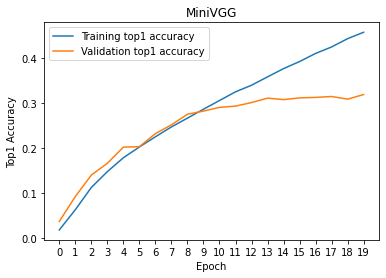

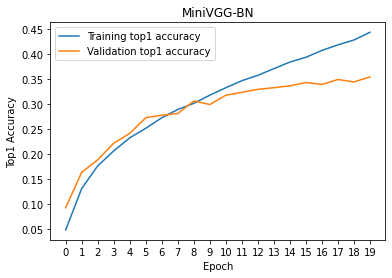

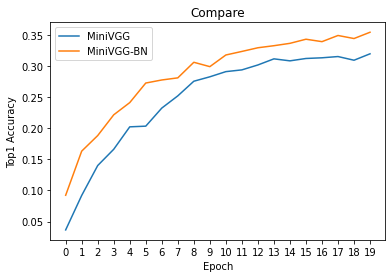

In [ ]:
x = np.arange(num_epochs)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, torch.tensor(tr_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, torch.tensor(tr_his_BN, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

In [ ]:
# # For EECS 504 students only other please delete/comment this cell

# # train/val accuracies for ResNet
# plt.figure()
# plt.plot(x, torch.tensor(tr_his_res, device = 'cpu'))
# plt.plot(x, torch.tensor(val_his_res, device = 'cpu'))
# plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
# plt.xticks(x)
# plt.xlabel('Epoch')
# plt.ylabel('Top1 Accuracy')
# plt.title('ResNet')
# plt.show()

### TODO: __Summarize the effect of batch normalization:__

# **5.1 d ANSWER:** Batch normalization (MiniVGG-BN) seems to improve the Top1 accuracy of every epoch compared to without (MiniVGG). 







In [ ]:
pickle.dump(tr_his, open('tr_his.pkl', 'wb'))
pickle.dump(tr_his_BN, open('tr_his_BN.pkl', 'wb'))
pickle.dump(val_his, open('val_his.pkl', 'wb'))
pickle.dump(val_his_BN, open('val_his_BN.pkl', 'wb'))

In [ ]:
pickle.dump(tr_his_res, open('tr_his_res.pkl', 'wb'))
pickle.dump(val_his_res, open('val_his_res.pkl', 'wb'))

NameError: ignored

## Step 6. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [ ]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values 
    of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the 
                network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [ ]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####
vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

Top-1 accuracy 35.73%, Top-5 accuracy 65.22%
Top-1 accuracy 31.7%, Top-5 accuracy 60.86%


In [ ]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####

# For EECS 504 students only other please delete/comment this cell

resnet.load_state_dict(torch.load('./weights/ResNet.pth'))
test(resnet, dataloaders['test'])

In [ ]:
##### Download pretrained weights (TODO: remove for student version) #####

# !wget http://www.eecs.umich.edu/courses/eecs504/MiniVGG-BN.pth
# !wget http://www.eecs.umich.edu/courses/eecs504/MiniVGG.pth

# features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
# vgg_BN = VGG(features).to(device)

# features = make_layers(cfgs['MiniVGG'], batch_norm=False)
# vgg = VGG(features).to(device)

# vgg_BN.load_state_dict(torch.load('MiniVGG-BN.pth'))
# vgg.load_state_dict(torch.load('MiniVGG.pth'))

# test(vgg_BN, dataloaders['test'])
# test(vgg, dataloaders['test'])

# Convert Notebook to PDF


In [1]:
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)

Mounted at /content/drive/


In [2]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

# Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442_PS4_FA_2022_Starter_Code.ipynb'
notebookpath = '/content/drive/My Drive/Colab Notebooks/Copy_of_ps5.ipynb' 

file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
files.download(notebookpath.split('.')[0]+'.pdf')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [1,187 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get

FileNotFoundError: ignored

[Alternative, if the above cell doesn't work.](https://docs.google.com/document/d/1QTutnoApRow8cOxNrKK6ISEkA72QGfwLFXbIcpvarAI/edit?usp=sharing).